In [1]:
#imports
import pandas as pd
#import yaml
from datetime import date,datetime
import pandas as pd
import matplotlib.pyplot as plt
from segmented_monte_carlo import SegmentedMonteCarlo
from segmented_monte_carlo_multinominal import SegmentedMonteCarlo
from joblib import Parallel, delayed, parallel_backend
import numpy as np
import multiprocessing as mp
import re
import json
import glob
import argparse
import datetime, time
import seaborn as sns
from datetime import datetime
import math
import random
from tqdm import tqdm
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from numpy import nan
from collections import defaultdict
from sympy.utilities.iterables import multiset_permutations
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
def create_arg_parser():
    parser = argparse.ArgumentParser(description='Please enter the file path to data source with the -d option. Load a preprocesed dataframe with the -r option.')
    parser.add_argument('-d', type=str, default="./data/T20I/", help='file path to data directory')
    parser.add_argument('-o', type=int, default=20, help='give the number of overs in a game')
    parser.add_argument('-w', type=int, default=10, help='give the number of max wickets in a game')
    parser.add_argument('-r', dest='df', action='store_true', help='reload a preprocessed dataframe as data source')
    parser.set_defaults(df=False)
    return parser
args=create_arg_parser().parse_args("")

In [3]:
match_data=pd.read_csv(args.d+"stats/game_stats.csv")
game_table=pd.read_csv(args.d+"stats/game_table.csv")
score_1=match_data.groupby(['team_1'])["score_1"].mean().sort_values()
score_2=match_data.groupby(['team_2'])["score_2"].mean().sort_values()

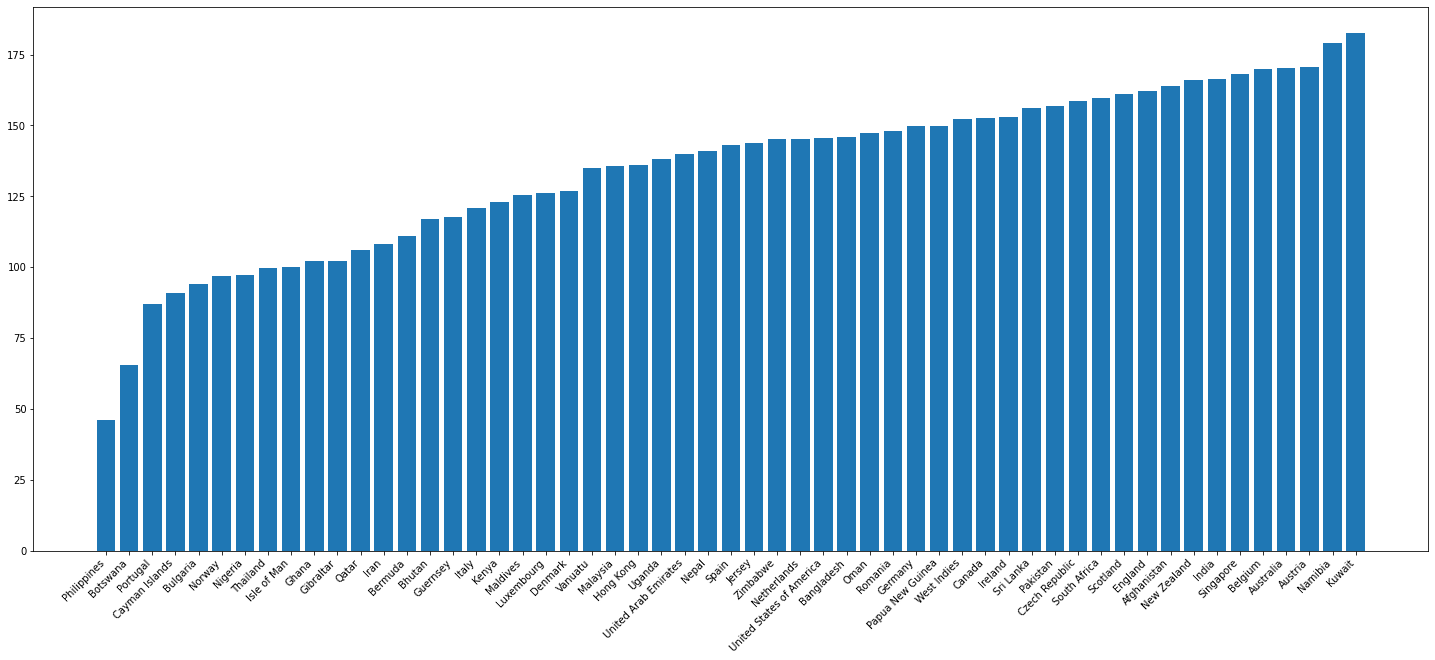

In [4]:
fig,ax=plt.subplots(figsize=(25,10))
plt.bar(score_1.index,score_1)
plt.xticks(rotation=45, ha='right')
plt.show()

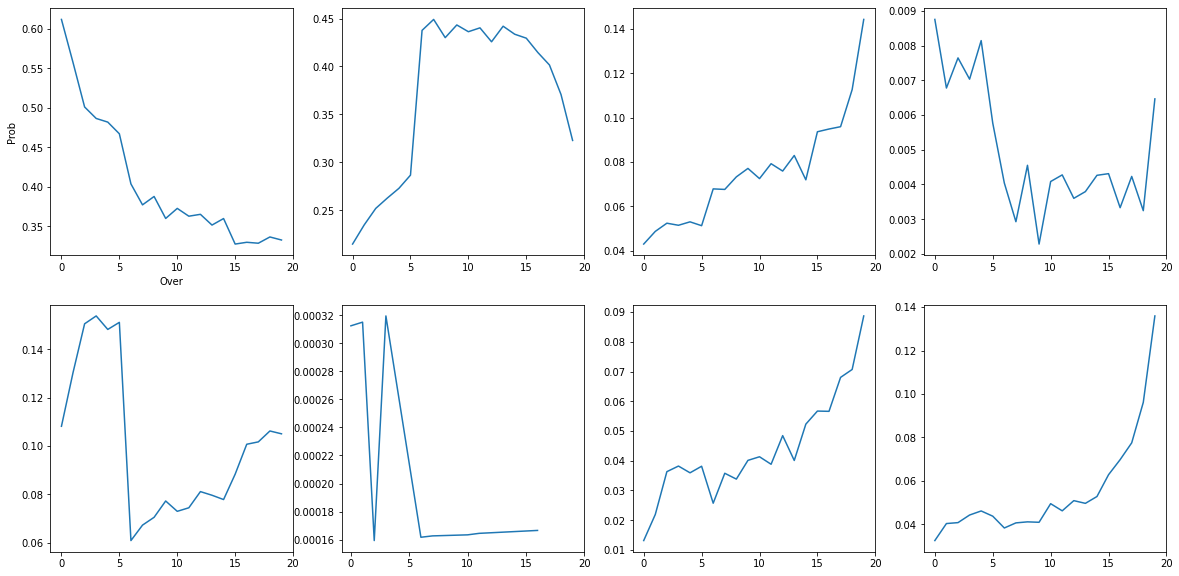

In [5]:
g=game_table[game_table.innings==1].groupby("overs")
r=g.runs_off_bat.value_counts(normalize=True)
ro=pd.DataFrame(r)
ro.index = ro.index.set_names(['over', 'rob'])
ro.reset_index(inplace=True)
w=g.wicket_scored.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6]
for i in pos:
    ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
    ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

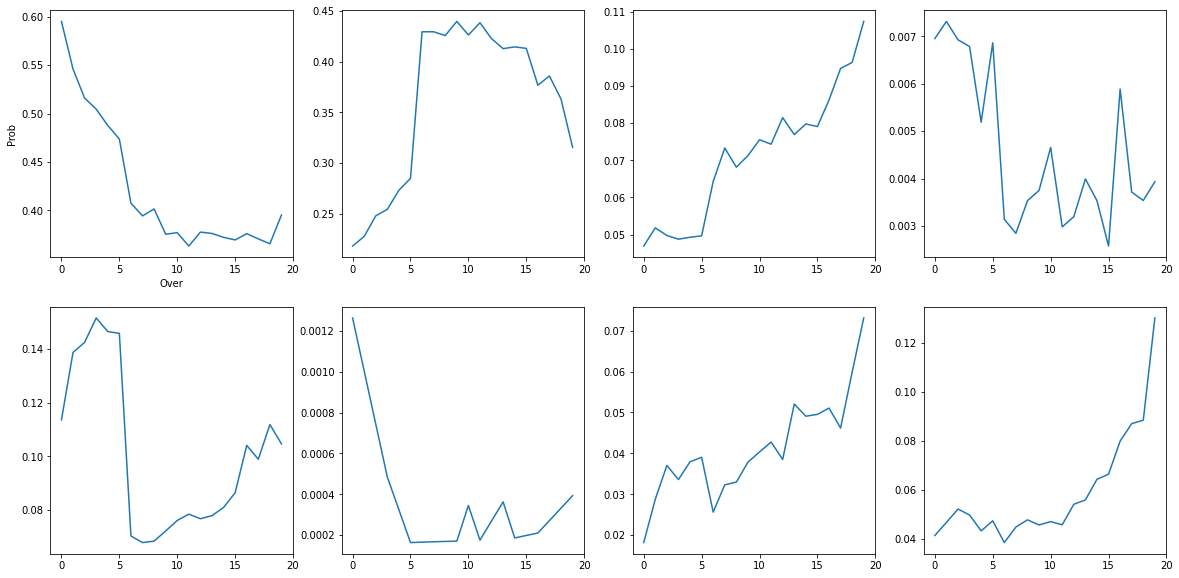

In [6]:
g=game_table[game_table.innings==2].groupby("overs")
r=g.runs_off_bat.value_counts(normalize=True)
ro=pd.DataFrame(r)
ro.index = ro.index.set_names(['over', 'rob'])
ro.reset_index(inplace=True)
w=g.wicket_scored.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6]
for i in pos:
    ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
    ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

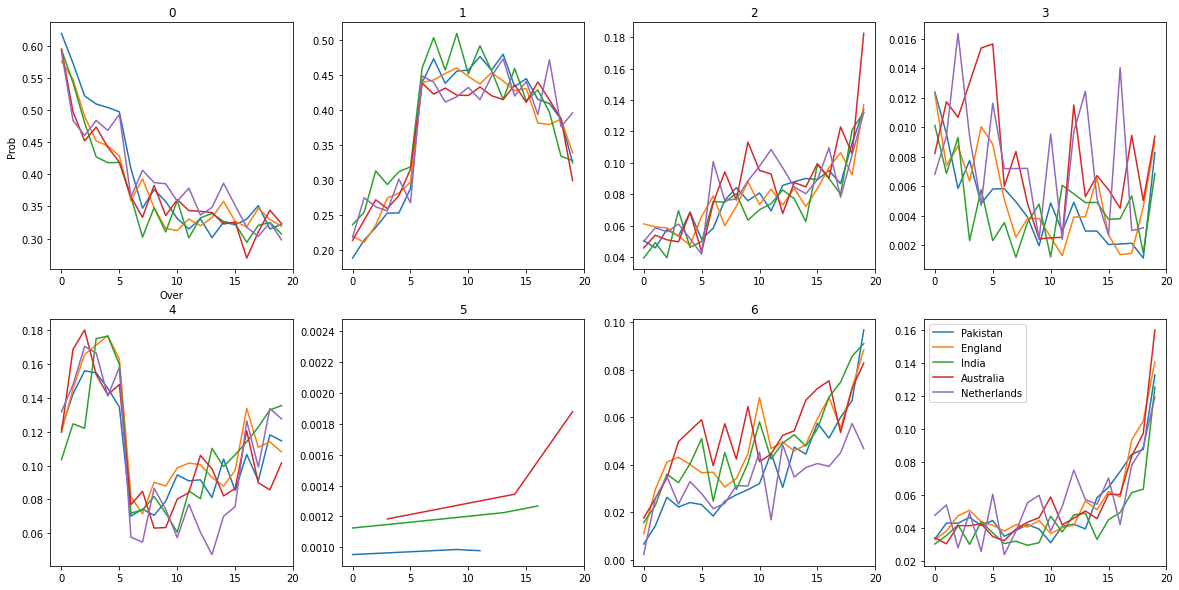

In [7]:
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
for t in ["Pakistan","England","India","Australia","Netherlands"]:
    g=game_table[game_table.batting_team==t].groupby("overs")
    r=g.runs_off_bat.value_counts(normalize=True)
    ro=pd.DataFrame(r)
    ro.index = ro.index.set_names(['over', 'rob'])
    ro.reset_index(inplace=True)
    w=g.wicket_scored.value_counts(normalize=True)
    wo=pd.DataFrame(w)
    wo.index = wo.index.set_names(['over', 'ws'])
    wo.reset_index(inplace=True)
    pos=[0,1,2,3,4,5,6]
    for i in pos:
        ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
        ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
        ax[i//4,i%4].set_title(i)
    ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
    ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.legend(["Pakistan","England","India","Australia","Netherlands"])
plt.show()

     over    ws  wickets_remain
0       0  10.0        0.922632
1       0   9.0        0.074711
2       0   8.0        0.002657
3       1  10.0        0.734752
4       1   9.0        0.231206
..    ...   ...             ...
161    19   1.0        0.077752
162    19   7.0        0.068594
163    19   8.0        0.026396
164    19   9.0        0.003053
165    19  10.0        0.000539

[166 rows x 3 columns]
     over    ws  wickets_remain
0       0  10.0        0.903318
1       0   9.0        0.091469
2       0   8.0        0.005213
3       1  10.0        0.683834
4       1   9.0        0.257352
..    ...   ...             ...
163    19   5.0        0.128982
164    19   6.0        0.051907
165    19   7.0        0.038144
166    19   8.0        0.006292
167    19   9.0        0.003146

[168 rows x 3 columns]


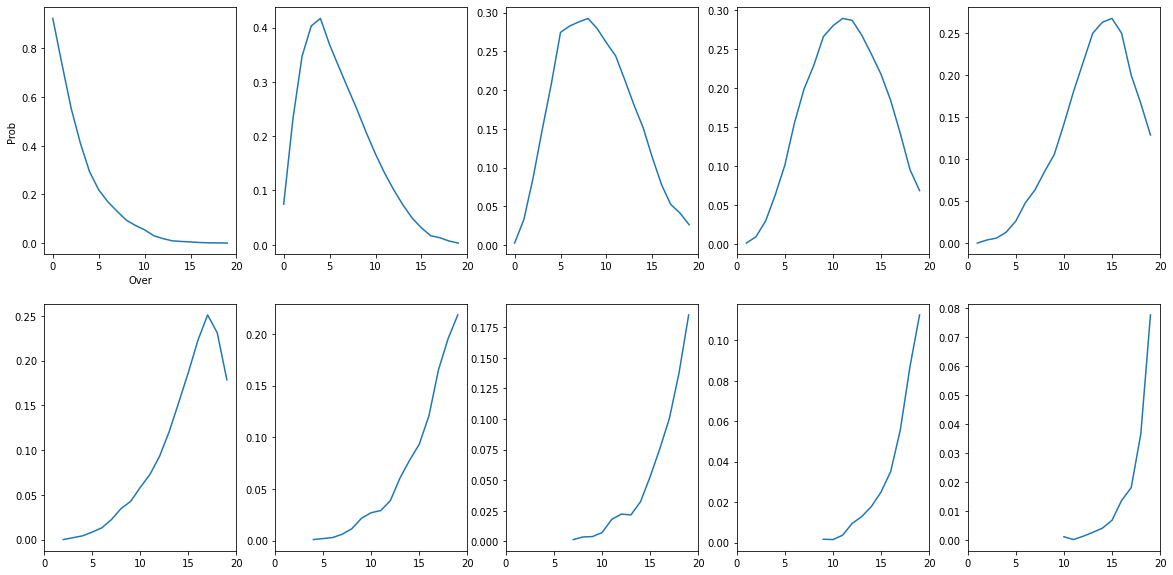

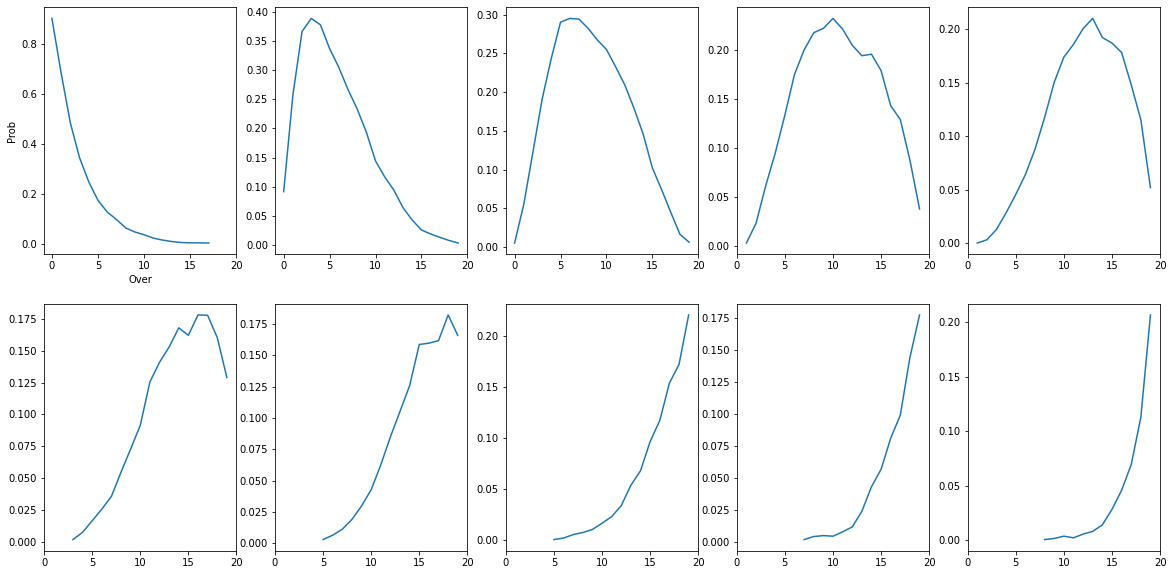

In [8]:
g=game_table[game_table.innings==1].groupby("overs")
w=g.wickets_remain.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
print(wo)
fig,ax=plt.subplots(2,5,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6,7,8,9]
for i in pos:
    ax[i//5,i%5].plot(wo[10-wo.ws==i].over,wo[10-wo.ws==i].wickets_remain)
    ax[i//5,i%5].xaxis.set_ticks(np.arange(0, 21, 5))
g=game_table[game_table.innings==2].groupby("overs")
w=g.wickets_remain.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
print(wo)
fig,ax=plt.subplots(2,5,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6,7,8,9]
for i in pos:
    ax[i//5,i%5].plot(wo[10-wo.ws==i].over,wo[10-wo.ws==i].wickets_remain)
    ax[i//5,i%5].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

In [9]:
over_segments=[0,6,11,14,17,20]
def team_test(bowlers,strikers,mint=100,maxt=250,overs=20,num_iter=1000):
    monte_carlo = SegmentedMonteCarlo(d="./data/T20I/", num_iter=num_iter)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"].values
    extras_bowlers=bowlers["extras_bowler"].values
    players_wb = strikers["wb"].values
    players_sr = strikers["strike_rate"].values
    players_av = strikers["striker_average"].values
    econ=bowlers["economy"].values
    probs = []
    job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av, extras_strikers, extras_bowlers, 1,
           len(over_segments) - 1)
    #print(job)
    results = monte_carlo.simulate_segment(job)
    # print(probs)
    # t = time.time()
    # jobs=[]
    # for t in range(mint,maxt):
    #    jobs.append((t, b, w, rrr, sr, sr_two, players_wb, bow, players_sr, players_av, extras_strikers, extras_bowlers, 2, len(over_segments) - 1))
    # with parallel_backend('loky', n_jobs=num_cores):
    #    prob = Parallel()(delayed(monte_carlo.simulate_segment)(j,True) for j in jobs)
    # print(time.time()-t)
    # print(prob)
    # print(np.array(probs)-np.array(prob))
    return results

In [10]:
def chase_prob(bowlers,strikers,mint=100,maxt=250,overs=20):
    monte_carlo = SegmentedMonteCarlo(d="./data/allT20/", num_iter=1000)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"]
    extras_bowlers=bowlers["extras_bowler"]
    players_wb = strikers["wb"]
    players_sr = strikers["strike_rate"]
    players_av = strikers["striker_average"]
    econ=bowlers["economy"]
    probs = []
    for r in range(mint,maxt,2):
        rrr=r/b
        job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av, extras_strikers, extras_bowlers, 2,
               len(over_segments) - 1)
        results = monte_carlo.simulate_segment(job)
        p = len(results[results<0]) / len(results)
        probs.append(p)
        #print(probs)
    return probs

In [11]:
def get_game_stats(players, strikers=True, team="",min_dismissed=5,date=None):
    columns=["player","team","games_played","runs","balls_striker","dismissed","extras_striker","strike_rate","wb","striker_average","concived_runs","balls_bowler","extras_bowler","economy","positions_striker","positions_bowler"]
    stats=pd.DataFrame(columns=columns)
    stats["player"]=players
    stats["team"]=[team for i in range(len(stats))]
    if strikers:
        for s in players:
            runs=runs_sheet[s][runs_sheet.date<date].sum()
            stats["runs"][stats["player"]==s]=runs
            balls=balls_sheet[s][balls_sheet.date<date].sum()
            stats["balls_striker"][stats["player"]==s]=balls
            stats["games_played"][stats["player"]==s]=balls_sheet[s].count()
            dismissed=dismissed_sheet[s][dismissed_sheet.date<date].sum()
            stats["dismissed"][stats["player"]==s]=dismissed
            extras=extras_striker_sheet[s][extras_striker_sheet.date<date].sum()/balls
            stats["extras_striker"][stats["player"]==s]=extras
            sr=runs/balls*100
            stats["strike_rate"][stats["player"]==s]=sr
            wb=balls/dismissed
            stats["wb"][stats["player"]==s]=wb
            avg=runs/dismissed
            stats["striker_average"][stats["player"]==s]=avg
            stats["positions_striker"][stats["player"]==s]=positions_striker_sheet[s]
        while len(stats)<11:
            stats=stats.append(stats.iloc[np.random.randint(0,len(stats))])
        stats["wb"]=stats["wb"].astype(np.float)
        stats["strike_rate"]=stats["strike_rate"].astype(np.float)
        stats["extras_striker"]=stats["extras_striker"].astype(np.float)
        stats["striker_average"]=stats["striker_average"].astype(np.float)
        return stats
    else:
        for b in players:
            #print(positions_bowler_sheet[b].value_counts())
            concived=concived_runs_sheet[b][concived_runs_sheet.date<date].sum()
            stats["concived_runs"][stats["player"]==b]=concived
            balls_bowler=balls_bowler_sheet[b][balls_bowler_sheet.date<date].sum()
            stats["balls_bowler"][stats["player"]==b]=balls_bowler
            extras_bowler=extras_bowler_sheet[b][extras_bowler_sheet.date<date].sum()/balls_bowler
            stats["extras_bowler"][stats["player"]==b]=extras_bowler
            er=concived/(balls_bowler/6)
            stats["economy"][stats["player"]==b]=er
        while len(stats)<11:
            stats=stats.append(stats.iloc[np.random.randint(0,len(stats))]) 
        stats["economy"]=stats["economy"].astype(np.float)
        stats["extras_bowler"]=stats["extras_bowler"].astype(np.float)
        return stats
t20i_path=args.d
runs_sheet=pd.read_csv(t20i_path+"/stats/runs_player_stats.csv")
balls_sheet=pd.read_csv(t20i_path+"/stats/balls_player_stats.csv")
dismissed_sheet=pd.read_csv(t20i_path+"/stats/dismissed_player_stats.csv")
concived_runs_sheet=pd.read_csv(t20i_path+"/stats/concived_runs_player_stats.csv")
balls_bowler_sheet=pd.read_csv(t20i_path+"/stats/balls_bowl_player_stats.csv")
extras_striker_sheet=pd.read_csv(t20i_path+"/stats/extras_striker_player_stats.csv")
extras_bowler_sheet=pd.read_csv(t20i_path+"/stats/extras_bowler_player_stats.csv")
positions_striker_sheet=pd.read_csv(t20i_path+"/stats/striker_position_player_stats.csv")
positions_bowler_sheet=pd.read_csv(t20i_path+"/stats/bowler_position_player_stats.csv")

In [12]:
game_table=pd.read_csv(args.d+"/stats/game_table_norm.csv")
print(game_table.info())
g = game_table[game_table.rain==False]
g = g[game_table.runs_off_bat != 7]
g = g[g.games_striker > 3]
g = g[g.games_bowler > 3]
print(g.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231761 entries, 0 to 231760
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              231761 non-null  int64  
 1   Unnamed: 0.1            231761 non-null  int64  
 2   match_id                231761 non-null  int64  
 3   season                  231761 non-null  object 
 4   start_date              231761 non-null  object 
 5   venue                   231761 non-null  object 
 6   innings                 231761 non-null  int64  
 7   ball                    231761 non-null  float64
 8   batting_team            231761 non-null  object 
 9   bowling_team            231761 non-null  object 
 10  striker                 231761 non-null  object 
 11  non_striker             231761 non-null  object 
 12  bowler                  231761 non-null  object 
 13  runs_off_bat            231761 non-null  int64  
 14  extras              

In [13]:
over_segments=[0,6,11,17,20]
def team_test(bowlers,strikers,mint=100,maxt=250,overs=20,num_iter=1000):
    monte_carlo = SegmentedMonteCarlo(d="./data/T20I/", num_iter=num_iter)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"].values
    extras_bowlers=bowlers["extras_bowler"].values
    players_wb = strikers["w_b"].values
    players_sr = strikers["s_r_career"].values
    players_av = strikers["Av_career"].values
    econ=bowlers["e_r_career"].values
    pf=strikers["striker_performance"].values
    probs = []
    job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av,pf, extras_strikers, extras_bowlers, 1,
           len(over_segments) - 1)
    #print(job)
    results = monte_carlo.simulate_segment(job)
    # print(probs)
    # t = time.time()
    # jobs=[]
    # for t in range(mint,maxt):
    #    jobs.append((t, b, w, rrr, sr, sr_two, players_wb, bow, players_sr, players_av, extras_strikers, extras_bowlers, 2, len(over_segments) - 1))
    # with parallel_backend('loky', n_jobs=num_cores):
    #    prob = Parallel()(delayed(monte_carlo.simulate_segment)(j,True) for j in jobs)
    # print(time.time()-t)
    # print(prob)
    # print(np.array(probs)-np.array(prob))
    return results

In [14]:
game_table=pd.read_csv(args.d+"/stats/game_table.csv")
print(np.min(game_table.rr),np.max(game_table.rr))
print(np.min(game_table.sr),np.max(game_table.sr))
print(np.min(game_table.rrr),np.max(game_table.rrr))

0.0 3.6666666666666665
0.0 172.0
-0.3684210526315789 143.0


1243389 [153 157 180 159 198 164]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
163.532
[0, 1, 2, 3, 5, 4, 6, 7, 8, 9, 10]
163.084
[0, 1, 2, 4, 3, 5, 6, 7, 8, 9, 10]
166.808
[0, 1, 2, 4, 5, 3, 6, 7, 8, 9, 10]
165.24
[0, 1, 2, 5, 3, 4, 6, 7, 8, 9, 10]
166.1
[0, 1, 2, 5, 4, 3, 6, 7, 8, 9, 10]
164.692
[0, 1, 3, 2, 4, 5, 6, 7, 8, 9, 10]
167.356
[0, 1, 3, 2, 5, 4, 6, 7, 8, 9, 10]
165.1
[0, 1, 3, 4, 2, 5, 6, 7, 8, 9, 10]
164.788
[0, 1, 3, 4, 5, 2, 6, 7, 8, 9, 10]
167.968
[0, 1, 3, 5, 2, 4, 6, 7, 8, 9, 10]
167.444
[0, 1, 3, 5, 4, 2, 6, 7, 8, 9, 10]
164.68
[0, 1, 4, 2, 3, 5, 6, 7, 8, 9, 10]
166.268
[0, 1, 4, 2, 5, 3, 6, 7, 8, 9, 10]
167.384
[0, 1, 4, 3, 2, 5, 6, 7, 8, 9, 10]
164.54
[0, 1, 4, 3, 5, 2, 6, 7, 8, 9, 10]
164.42
[0, 1, 4, 5, 2, 3, 6, 7, 8, 9, 10]
166.568
[0, 1, 4, 5, 3, 2, 6, 7, 8, 9, 10]
165.728
[0, 1, 5, 2, 3, 4, 6, 7, 8, 9, 10]
166.976
[0, 1, 5, 2, 4, 3, 6, 7, 8, 9, 10]
166.908
[0, 1, 5, 3, 2, 4, 6, 7, 8, 9, 10]
167.436
[0, 1, 5, 3, 4, 2, 6, 7, 8, 9, 10]
164.54
[0, 1, 5, 4, 2, 3, 6, 7, 8, 9

164.76
[1, 3, 5, 4, 2, 0, 6, 7, 8, 9, 10]
164.804
[1, 4, 0, 2, 3, 5, 6, 7, 8, 9, 10]
169.524
[1, 4, 0, 2, 5, 3, 6, 7, 8, 9, 10]
165.612
[1, 4, 0, 3, 2, 5, 6, 7, 8, 9, 10]
162.668
[1, 4, 0, 3, 5, 2, 6, 7, 8, 9, 10]
167.08
[1, 4, 0, 5, 2, 3, 6, 7, 8, 9, 10]
165.888
[1, 4, 0, 5, 3, 2, 6, 7, 8, 9, 10]
163.868
[1, 4, 2, 0, 3, 5, 6, 7, 8, 9, 10]
164.58
[1, 4, 2, 0, 5, 3, 6, 7, 8, 9, 10]
165.42
[1, 4, 2, 3, 0, 5, 6, 7, 8, 9, 10]
164.664
[1, 4, 2, 3, 5, 0, 6, 7, 8, 9, 10]
165.456
[1, 4, 2, 5, 0, 3, 6, 7, 8, 9, 10]
166.32
[1, 4, 2, 5, 3, 0, 6, 7, 8, 9, 10]
164.0
[1, 4, 3, 0, 2, 5, 6, 7, 8, 9, 10]
165.992
[1, 4, 3, 0, 5, 2, 6, 7, 8, 9, 10]
165.212
[1, 4, 3, 2, 0, 5, 6, 7, 8, 9, 10]
167.376
[1, 4, 3, 2, 5, 0, 6, 7, 8, 9, 10]
166.216
[1, 4, 3, 5, 0, 2, 6, 7, 8, 9, 10]
165.864
[1, 4, 3, 5, 2, 0, 6, 7, 8, 9, 10]
163.492
[1, 4, 5, 0, 2, 3, 6, 7, 8, 9, 10]
164.752
[1, 4, 5, 0, 3, 2, 6, 7, 8, 9, 10]
166.88
[1, 4, 5, 2, 0, 3, 6, 7, 8, 9, 10]
165.612
[1, 4, 5, 2, 3, 0, 6, 7, 8, 9, 10]
165.008
[1, 4, 5, 3

164.656
[3, 0, 5, 4, 2, 1, 6, 7, 8, 9, 10]
166.812
[3, 1, 0, 2, 4, 5, 6, 7, 8, 9, 10]
164.212
[3, 1, 0, 2, 5, 4, 6, 7, 8, 9, 10]
165.86
[3, 1, 0, 4, 2, 5, 6, 7, 8, 9, 10]
165.292
[3, 1, 0, 4, 5, 2, 6, 7, 8, 9, 10]
162.048
[3, 1, 0, 5, 2, 4, 6, 7, 8, 9, 10]
166.74
[3, 1, 0, 5, 4, 2, 6, 7, 8, 9, 10]
164.66
[3, 1, 2, 0, 4, 5, 6, 7, 8, 9, 10]
163.552
[3, 1, 2, 0, 5, 4, 6, 7, 8, 9, 10]
165.288
[3, 1, 2, 4, 0, 5, 6, 7, 8, 9, 10]
163.392
[3, 1, 2, 4, 5, 0, 6, 7, 8, 9, 10]
163.808
[3, 1, 2, 5, 0, 4, 6, 7, 8, 9, 10]
166.116
[3, 1, 2, 5, 4, 0, 6, 7, 8, 9, 10]
166.26
[3, 1, 4, 0, 2, 5, 6, 7, 8, 9, 10]
162.224
[3, 1, 4, 0, 5, 2, 6, 7, 8, 9, 10]
168.132
[3, 1, 4, 2, 0, 5, 6, 7, 8, 9, 10]
165.492
[3, 1, 4, 2, 5, 0, 6, 7, 8, 9, 10]
164.912
[3, 1, 4, 5, 0, 2, 6, 7, 8, 9, 10]
162.66
[3, 1, 4, 5, 2, 0, 6, 7, 8, 9, 10]
162.412
[3, 1, 5, 0, 2, 4, 6, 7, 8, 9, 10]
167.952
[3, 1, 5, 0, 4, 2, 6, 7, 8, 9, 10]
163.628
[3, 1, 5, 2, 0, 4, 6, 7, 8, 9, 10]
166.228
[3, 1, 5, 2, 4, 0, 6, 7, 8, 9, 10]
165.372
[3, 1, 5

166.552
[4, 3, 5, 2, 1, 0, 6, 7, 8, 9, 10]
163.18
[4, 5, 0, 1, 2, 3, 6, 7, 8, 9, 10]
164.608
[4, 5, 0, 1, 3, 2, 6, 7, 8, 9, 10]
165.012
[4, 5, 0, 2, 1, 3, 6, 7, 8, 9, 10]
165.46
[4, 5, 0, 2, 3, 1, 6, 7, 8, 9, 10]
167.92
[4, 5, 0, 3, 1, 2, 6, 7, 8, 9, 10]
161.916
[4, 5, 0, 3, 2, 1, 6, 7, 8, 9, 10]
166.024
[4, 5, 1, 0, 2, 3, 6, 7, 8, 9, 10]
166.676
[4, 5, 1, 0, 3, 2, 6, 7, 8, 9, 10]
168.068
[4, 5, 1, 2, 0, 3, 6, 7, 8, 9, 10]
167.488
[4, 5, 1, 2, 3, 0, 6, 7, 8, 9, 10]
164.788
[4, 5, 1, 3, 0, 2, 6, 7, 8, 9, 10]
166.024
[4, 5, 1, 3, 2, 0, 6, 7, 8, 9, 10]
163.64
[4, 5, 2, 0, 1, 3, 6, 7, 8, 9, 10]
165.092
[4, 5, 2, 0, 3, 1, 6, 7, 8, 9, 10]
163.156
[4, 5, 2, 1, 0, 3, 6, 7, 8, 9, 10]
164.364
[4, 5, 2, 1, 3, 0, 6, 7, 8, 9, 10]
165.224
[4, 5, 2, 3, 0, 1, 6, 7, 8, 9, 10]
161.756
[4, 5, 2, 3, 1, 0, 6, 7, 8, 9, 10]
165.764
[4, 5, 3, 0, 1, 2, 6, 7, 8, 9, 10]
165.868
[4, 5, 3, 0, 2, 1, 6, 7, 8, 9, 10]
166.828
[4, 5, 3, 1, 0, 2, 6, 7, 8, 9, 10]
167.42
[4, 5, 3, 1, 2, 0, 6, 7, 8, 9, 10]
163.7
[4, 5, 3, 

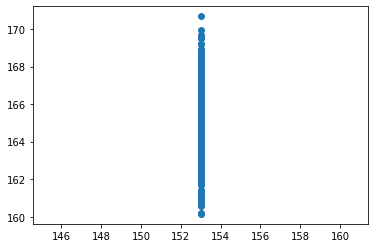

In [15]:
def test_match(t1="England",t2="India"):
    pss=[]
    rss=[]
    stds=[]
    a=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[-1]#[match_data.team_2==t2]
    date_a=match_data[match_data.team_1==t1][match_data.team_2==t2].start_date.values[-1]
    s1=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].score_1.values
    print(a,s1)
    sai=pd.DataFrame()
    bai=pd.DataFrame()
    for c in ["balls_remain", "wickets_remain", "rr", "sr", "w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
        sai[c]=[np.nan for i in range(11)]
    for c in ["e_r_career","extras_bowler"]:
        bai[c]=[np.nan for i in range(11)]
    ind=[i for i in range(6)]
    per=multiset_permutations(ind)
    for p in per:
        p=p+[6,7,8,9,10]
        for c in ["w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            sai[c].iloc[:len(u)]=u
            sai[c].fillna(np.nanmean(sai[c]),inplace=True)
        for c in ["e_r_career","extras_bowler"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            bai[c].iloc[:len(u)]=u
            bai[c].fillna(np.nanmean(bai[c]),inplace=True)
        saii=sai.reindex(p)
        print(p)
        #print(saii)
        try:
            res=team_test(bai,saii,num_iter=250)
            ps=np.mean(res)
            print(ps)
            std=np.std(res)
            pss.append(ps)
            rss.append(s1[0])
            stds.append(std)
            #plt.hist(res)
            #plt.show()
        except:
            pss.append(0)
            stds.append(0)
            continue
    plt.scatter(rss,pss)
    #plt.xlim([100, 250])
    #plt.ylim([100, 250])
    plt.show()
    return rss,pss
rss,pss=test_match()

In [19]:
t1="England"
t2="India"
print(match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[-1])
ind=[i for i in range(6)]
per=np.array(list(multiset_permutations(ind)))
per[list(np.argsort(pss))]

1243389


array([[2, 3, 0, 5, 4, 1],
       [2, 4, 3, 0, 5, 1],
       [3, 2, 1, 4, 5, 0],
       ...,
       [0, 3, 4, 1, 2, 5],
       [1, 5, 3, 0, 2, 4],
       [1, 0, 3, 5, 4, 2]])

In [22]:
 a=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[-1]
sai=pd.DataFrame()
bai=pd.DataFrame()
for c in ["striker","balls_remain", "wickets_remain", "rr", "sr", "w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
    sai[c]=[np.nan for i in range(11)]
for c in ["e_r_career","extras_bowler"]:
    bai[c]=[np.nan for i in range(11)]
for c in ["striker","w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
    u=g[g.match_id==a][g.innings==1][c].unique()
    sai[c].iloc[:len(u)]=u
    try:
        sai[c].fillna(np.nanmean(sai[c]),inplace=True)
    except:
        continue
for c in ["e_r_career","extras_bowler"]:
    u=g[g.match_id==a][g.innings==1][c].unique()
    bai[c].iloc[:len(u)]=u
    bai[c].fillna(np.nanmean(bai[c]),inplace=True)
print(sai)

print(np.array(pss)[list(np.argsort(pss))])

        striker  balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0        JJ Roy           NaN             NaN NaN NaN  0.155729    0.341256   
1    JC Buttler           NaN             NaN NaN NaN  0.164446    0.343750   
2      DJ Malan           NaN             NaN NaN NaN  0.288306    0.347364   
3   JM Bairstow           NaN             NaN NaN NaN  0.166398    0.338213   
4    EJG Morgan           NaN             NaN NaN NaN  0.166894    0.335742   
5     BA Stokes           NaN             NaN NaN NaN  0.133065    0.339286   
6     SM Curran           NaN             NaN NaN NaN  0.061290    0.302326   
7           NaN           NaN             NaN NaN NaN  0.162304    0.335419   
8           NaN           NaN             NaN NaN NaN  0.162304    0.335419   
9           NaN           NaN             NaN NaN NaN  0.162304    0.335419   
10          NaN           NaN             NaN NaN NaN  0.162304    0.335419   

    striker_performance  extras_striker  Av_career 